This is heavily based on the sample notebooks, and compares the work of Sartre and De Beauvoir, as pulled from HathiTrust Digital Library

In [44]:
!pip install htrc-feature-reader

In [143]:
from htrc_features import FeatureReader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [46]:
# input: document, output: tokens 
def get_htrc_page_data(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    ptc = vol.tokenlist(pos=False, case=False).reset_index().drop(['section'], axis=1)
    page_list = set(ptc['page'])
    
    # extract tokens by page 
    tokens=list()
    for page in page_list:
        page_data = str()
        
        # operate on each token
        for page_tokens in ptc.loc[ptc['page'] == page].iterrows():
            if page_tokens[1][1].isalpha():
                
                # deal with frequency count by creating correct number of tokens
                page_data += (' '.join([page_tokens[1][1]] * page_tokens[1][2])) + " "

        tokens.append(page_data.split())
    return tokens

In [47]:
# input: document, output: bibliographic data
def get_htrc_metadata(document):
    fr = FeatureReader([document])
    vol = next(fr.volumes())
    return([vol.author[0],vol.title,vol.year])

In [48]:
# htids for two classes/books
sartre = ["inu.30000007066859", "mdp.39015009099337", "pst.000028362555"]
de_beauvoir = ["inu.30000100635840", "mdp.39015004272384", "mdp.39015010722521"]

In [49]:
# construct dataframe to display texts
bib = list()
for doc in sartre + de_beauvoir:
    bib.append(get_htrc_metadata(doc))
df = pd.DataFrame(bib,columns=["Author","Title","Publication Year"])
df

,Author,Title,Publication Year
0,"Sartre, Jean-Paul, 1905-1980",The age of reason.,1964
1,"Sartre, Jean-Paul, 1905-1980.",Troubled sleep.,1964
2,"Sartre, Jean-Paul, 1905-1980","The wall, and other stories /",1948
3,"Beauvoir, Simone de, 1908-1986",The mandarins /,2005
4,"Beauvoir, Simone de, 1908-1986.",When things of the spirit come first : five ea...,1982
5,"Beauvoir, Simone de, 1908-1986.","The blood of others,",1948


In [50]:
page_tokens = get_htrc_page_data(sartre[1])

In [51]:
tokens = [w for p in page_tokens for w in p]

In [52]:
len(tokens)

124319

In [53]:
tokens[:15]

['i',
 'a',
 'about',
 'after',
 'analysis',
 'and',
 'and',
 'any',
 'be',
 'bitter',
 'by',
 'by',
 'captured',
 'compelling',
 'considered']

In [54]:
tokens.count("man")

303

In [55]:
tokens.count("woman")

61

In [56]:
tokens.count("power")

10

In [57]:
tokens.count("politics")

3

In [58]:
tokens.count("thought")

258

In [76]:
tokens.count("virtue")

4

In [92]:
# create labels for classifier
labels = ["sartre"] * len(sartre) + ["de beauvoir"] * len(de_beauvoir)

In [93]:
# construct text for consumption into dtm
raw_data = list()
for doc in sartre + de_beauvoir:
    page_data = get_htrc_page_data(doc)
    tokens = ' '.join([w for p in page_data for w in p])
    raw_data.append(tokens)

In [94]:
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
vec = CountVectorizer(input='content',
                             stop_words='english',
                             strip_accents='unicode')

In [96]:
dtm = vec.fit_transform(raw_data)
dtm_dense = dtm.todense()
dc, vc = dtm.shape
idx2voc = {v:k for k, v in vec.vocabulary_.items()}

In [97]:
def term_debug(term):
    idx = vec.vocabulary_[term]
    print("total count: {0}".format(int(np.sum(dtm,axis=0)[:, idx])))
    print("class 0: {0}".format(count_matrix[0,idx]))
    print("class 1: {0}".format(count_matrix[1,idx]))

In [98]:
# create priors and initialize matrices
priors = np.array([0.1 for i in range(vc)])
z_scores = np.empty(priors.shape[0])
count_matrix = np.empty([2, vc], dtype=np.float32)

# Summarize Class 0
count_matrix[0, :] = np.sum((dtm[0],dtm[2],dtm[3]),axis = 0).todense()

# Summarize Class 1
count_matrix[1, :] = np.sum((dtm[1],dtm[4],dtm[5]),axis = 0).todense()

In [84]:
a0 = np.sum(priors)
n1 = 1.*np.sum(count_matrix[0,:])
n2 = 1.*np.sum(count_matrix[1,:])

In [85]:
for i in range(vc):
    # compute delta
    term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
    term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
    delta = term1 - term2
    
    # compute variance on delta
    var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
    
    # store final score
    z_scores[i] = delta / np.sqrt(var)

In [86]:
# extract most significant terms
[(idx2voc[i], z_scores[i]) for i in np.argsort(z_scores)][:25]

[('brunet', -22.334254612613748),
 ('mme', -10.719908062151314),
 ('anne', -10.609038103492859),
 ('round', -10.361830432768647),
 ('andree', -10.120097458401407),
 ('gomez', -9.949333655623834),
 ('lisa', -9.19024214799066),
 ('men', -8.919050036334731),
 ('war', -8.171945939524852),
 ('paul', -8.100988577429984),
 ('stared', -7.647325526120154),
 ('hell', -7.44895495262391),
 ('soldiers', -7.367457953057242),
 ('road', -7.123109376006659),
 ('rose', -6.938517611612769),
 ('germans', -6.76101098524025),
 ('jean', -6.687131930809218),
 ('forward', -6.60164028698299),
 ('train', -6.572620056873001),
 ('peace', -6.473033378777957),
 ('moved', -6.465132869097542),
 ('schneider', -6.375937351943019),
 ('bread', -6.271791561823895),
 ('yvonne', -6.268674551630276),
 ('shouted', -6.199641982276482)]

In [87]:
# calculate absolute differences between our first and second text and display
# top 10 terms with the greatest difference. 
abs_diff = np.abs(dtm[0] - dtm[1])
for i in np.argsort(abs_diff.toarray()[0])[::-1][:10]:
    print("{0}: {1}".format(idx2voc[i],abs_diff.toarray()[0][i]))

mathieu: 794
brunet: 561
ivich: 537
boris: 382
daniel: 376
marcelle: 346
pinette: 340
schneider: 304
lola: 302
men: 185


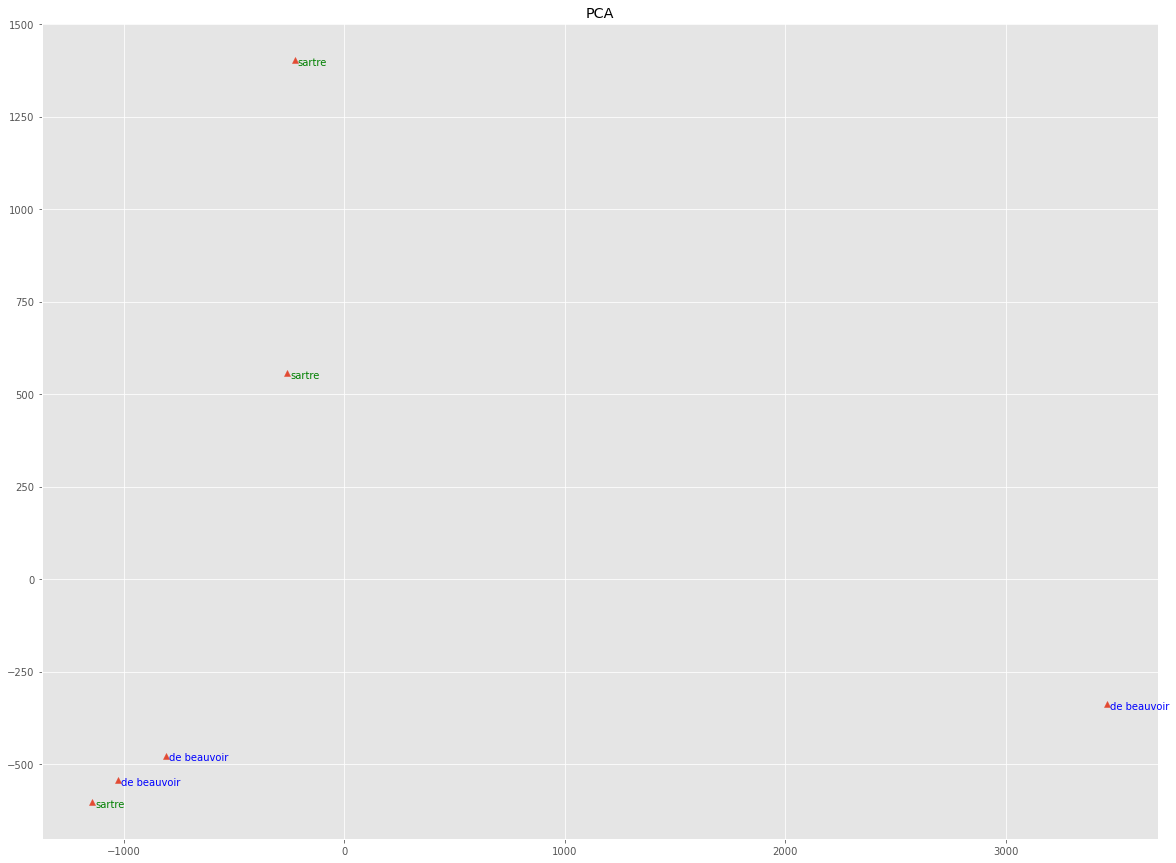

In [88]:
# simple PCA on DTM data
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # two components for plotting
plot_data = pca.fit_transform(np.asarray(dtm_dense))

from matplotlib import pyplot as plt
xs, ys = plot_data[:, 0], plot_data[:, 1]
fig = plt.figure(figsize=(20, 15))
plt.clf()
plt.title("PCA")
plt.style.use('ggplot')
plt.scatter(xs, ys, marker = '^')
cdict = {'sartre': 'green', 'de beauvoir': 'blue'}
for i, w in enumerate(labels):
    plt.annotate(w, xy = (xs[i], ys[i]), xytext = (3, 3),
                 textcoords = 'offset points', ha = 'left', va = 'top', c = cdict[labels[i]])
plt.show()

In [99]:
term_debug('man')

total count: 986
class 0: 556.0
class 1: 430.0


In [100]:
term_debug('woman')

total count: 566
class 0: 336.0
class 1: 230.0


In [101]:
term_debug('virtue')

total count: 11
class 0: 4.0
class 1: 7.0


In [125]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

clf = SGDClassifier(tol=None,max_iter=1000,random_state=50).fit(dtm,labels)

<AxesSubplot:title={'center':'Key Features: Sartre'}>

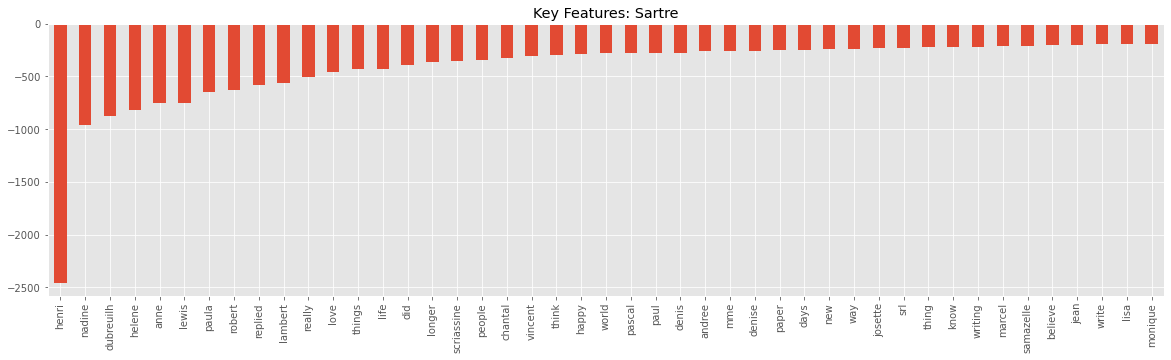

In [136]:
df = pd.DataFrame([clf.coef_[0][idx] for idx in np.argsort(clf.coef_[0])[:45]],
                  index = [vec.get_feature_names_out()[idx] for idx in np.argsort(clf.coef_[0])[:45]])
df.plot(figsize=(20, 5),kind='bar',title='Key Features: Sartre',legend=False)

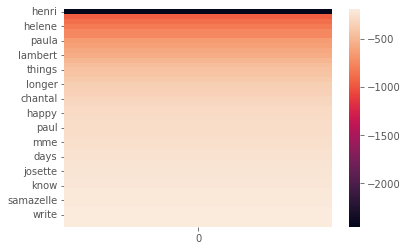

In [129]:
p1 = sns.heatmap(df)

In [110]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_similarity
cosine_dist_matrix = 1 - cosine_similarity(dtm)

%timeit
affprop = AffinityPropagation(random_state=None,affinity="precomputed", max_iter=1000, damping=0.99)
affprop.fit(cosine_dist_matrix)

AffinityPropagation(affinity='precomputed', damping=0.99, max_iter=1000)

In [111]:
# Display clusters
for cluster in np.unique(affprop.labels_):
    print(cluster," ".join(np.array(labels)[(affprop.labels_ == cluster)]))

0 sartre sartre sartre de beauvoir de beauvoir de beauvoir


In [112]:
page_tokens = get_htrc_page_data(de_beauvoir[1])

In [113]:
tokens = [w for p in page_tokens for w in p]

In [115]:
tokens[20:35]

['beauvoir',
 'blood',
 'boupacha',
 'brigitte',
 'burn',
 'by',
 'by',
 'came',
 'circumstance',
 'daughter',
 'day',
 'day',
 'de',
 'de',
 'death']

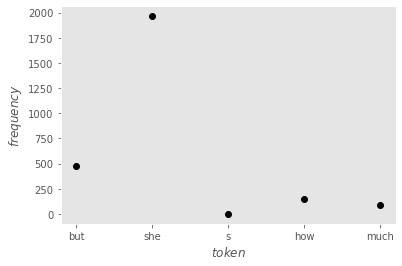

In [167]:
# each time you run this, it'll pick 5 random tokens and graph them vs frequency (can change the range of the for loop)
# add a grid
plt.grid()

# label axes
plt.xlabel("$token$")
plt.ylabel("$frequency$")

max = len(tokens)

for i in range(5):
    # generate a random index between 0 and the max
    i = int(random.randint(0,max))
    
    # plot this token
    x = str(tokens[i])
    y = tokens.count(x)
    plt.plot(x, y, 'ko')

plt.show()

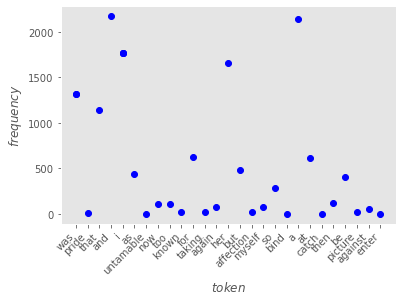

In [181]:
# same, with 50 tokens
# add a grid
plt.grid()

# label axes
plt.xlabel("$token$")
plt.ylabel("$frequency$")

plt.xticks(rotation=45, ha='right')

max = len(tokens)

for i in range(30):
    # generate a random index between 0 and the max
    i = int(random.randint(0,max))
    # plot this token
    x = str(tokens[i])
    y = tokens.count(x)
    plt.plot(x, y, 'bo')

plt.show()